In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20


from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sktime.transformations.series.boxcox import BoxCoxTransformer

from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import STL, MSTL

In [2]:
import statsmodels

statsmodels.__version__

'0.14.0.dev579+ga26536041'

In [3]:
df = pd.read_csv(
    "Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

In [4]:
df

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [5]:
def plot_ts(df, title_suffix = ""):

    ax = df.plot(figsize = (12,6), marker=".", legend = None);
    ax.set_xlabel("Time");
    ax.set_ylabel("Air passengers (1000s)");
    ax.set_title("Air passenger numbers" + title_suffix);
    plt.show();

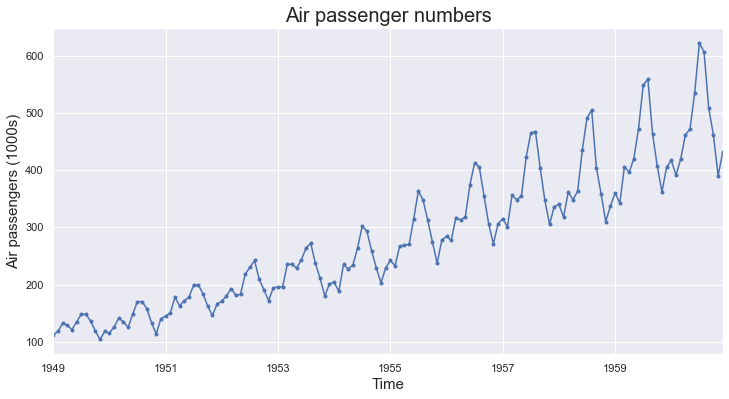

In [6]:
plot_ts(df = df)

### Apply BoxCox to convert multplicate TS to  additive TS tp make the Magnitude of the TS constant over time.

In [7]:
#Log transform by setting Lambda = 0
df["y_log"] = boxcox(df["y"], lmbda = 0)

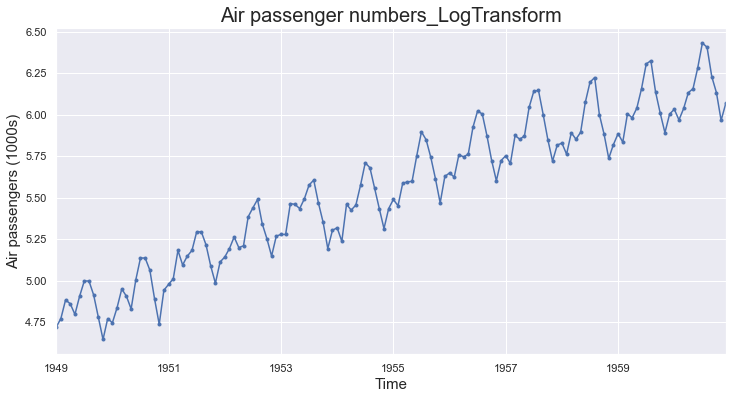

In [8]:
plot_ts(df = df["y_log"], title_suffix = "_LogTransform")

In [9]:
#Finding Lambda automatically by setting Lambda = None. Scipy uses maximum likelihood estimation (MLE) to
#find suitable lambda value

df["y_MLE"], mle_lmbda = boxcox(df["y"], lmbda = None)

MLE selected Lambda: 0.148


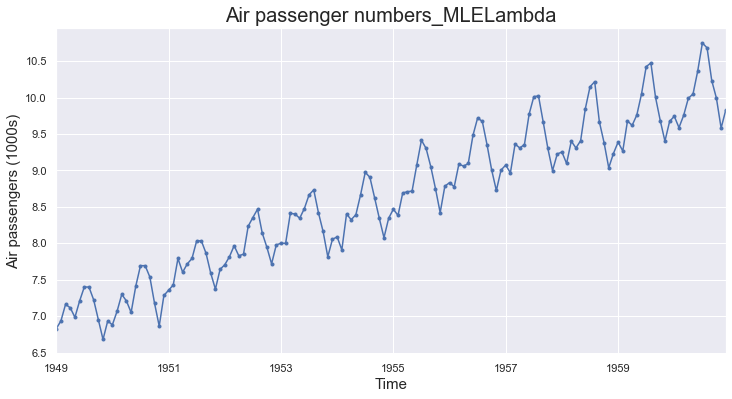

In [10]:
print(f"MLE selected Lambda: {mle_lmbda:.3f}")

plot_ts(df = df["y_MLE"], title_suffix = "_MLELambda")

# Estimating Lambda using guerrero is a better way

In [11]:
transformer = BoxCoxTransformer(
    method="guerrero",
    sp=12 # sp should be set to the seasonal period
)

df["y_guerrero"] = transformer.fit_transform(df["y"])

Guerrero selected Lambda: -0.295


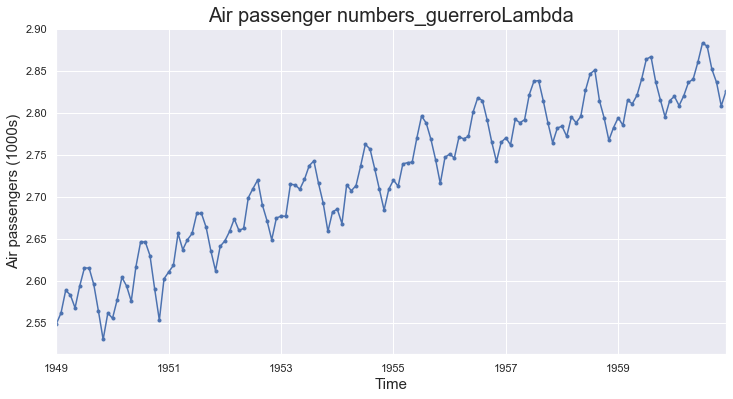

In [12]:
print(f"Guerrero selected Lambda: {transformer.lambda_:.3f}")

plot_ts(df = df["y_guerrero"], title_suffix = "_guerreroLambda")

# Extract Trend, seasonality and residual components from the above TS

In [13]:
df.head()

,y,y_log,y_MLE,y_guerrero
ds,,,,
1949-01-01,112,4.718499,6.827490,2.548446
1949-02-01,118,4.770685,6.932822,2.561336
1949-03-01,132,4.882802,7.161892,2.588369
1949-04-01,129,4.859812,7.114611,2.582898
1949-05-01,121,4.795791,6.983787,2.567468


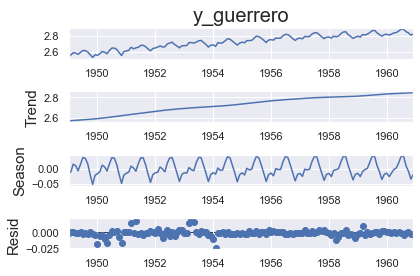

In [14]:
# Perform STL decomposition
res = STL(
    endog=df["y_guerrero"],  # Y values in addtive order
    period=12,  # The periodicity of the seasonal component
    seasonal=7,  # Determines the window size for LOESS used
    # when smoothing the seasonal component
    # (i.e, the cycle-subseries)
    robust=True  # Flag to use robust regression when
    # fitting the LOESS curves so the fit
    # is robust to outliers
).fit()


# plt.rc("figure", figsize=(10, 10))
# plt.rc("font", size=5)
res.plot();

In [15]:
# Extract the trend and seasonality individually
df["trend"] = res.trend
df["seasonal"] = res.seasonal
df.head()

,y,y_log,y_MLE,y_guerrero,trend,seasonal
ds,,,,,,
1949-01-01,112,4.718499,6.827490,2.548446,2.567293,-0.018008
1949-02-01,118,4.770685,6.932822,2.561336,2.568966,-0.008544
1949-03-01,132,4.882802,7.161892,2.588369,2.570650,0.016200
1949-04-01,129,4.859812,7.114611,2.582898,2.572349,0.010808
1949-05-01,121,4.795791,6.983787,2.567468,2.574066,-0.006623


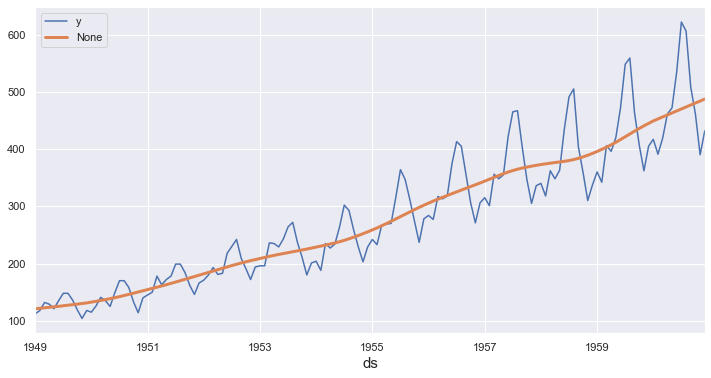

In [16]:
#Need to inverse transform trend inorder to plot with y

ax = df["y"].plot(figsize = (12, 6));
transformer.inverse_transform(df["trend"]).plot(lw = 3,);

plt.legend();

# Alternatvely, Performing STL directly on y without converting TS to additive model.

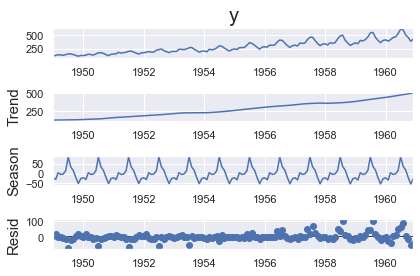

In [17]:
#check notebook about seasonal_deg parameter. This is done mostly to obtain an additive seasonality.


# Perform STL decomposition
res = STL(
    endog=df["y"],  # Y values in addtive order
    period=12,  # The periodicity of the seasonal component
    seasonal=31,  # Determines the window size for LOESS used
    # when smoothing the seasonal component
    # (i.e, the cycle-subseries)
    seasonal_deg=0, 
    robust=True  # Flag to use robust regression when
    # fitting the LOESS curves so the fit
    # is robust to outliers
).fit()


# plt.rc("figure", figsize=(10, 10))
# plt.rc("font", size=5)
res.plot();

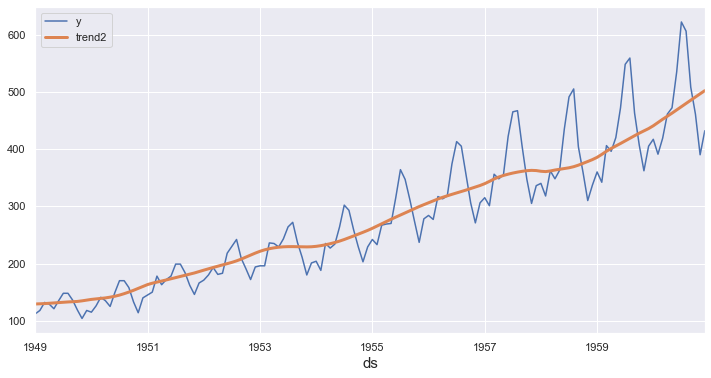

In [18]:
df["trend2"] = res.trend
df["seasonal2"] = res.seasonal

ax = df["y"].plot(figsize = (12, 6));
df["trend2"].plot(lw = 3,);

plt.legend();

# MSTL - Decomposition of time series having multiple seasonalities

In [19]:
df = pd.read_csv(
    "Datasets/victoria_electricity_demand.csv",
    usecols=["date_time", "demand"],
    parse_dates=["date_time"],
    index_col=["date_time"],
)

df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115368 entries, 2002-01-01 00:00:00 to 2015-02-28 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   demand  115368 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [21]:
#taking a subset of data
sd = pd.to_datetime("2012-01-01")

df_smpl = df.loc[sd: sd + pd.Timedelta("149D")] # from 1 day of 2012 until 149 days after the start date.

# Compute date time variables used later in plotting
df_smpl["week"] = df_smpl.index.isocalendar().week
df_smpl["day_of_month"] = df_smpl.index.day
df_smpl["month"] = df_smpl.index.month

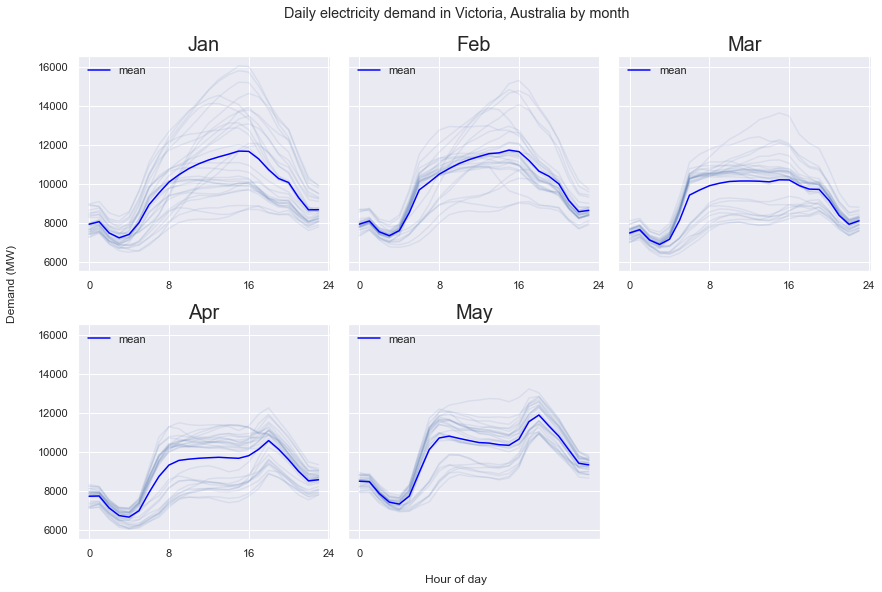

In [22]:
# Plot the electricity demand for each day in each month
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[12, 8], sharey=True)
ax = ax.flatten()

sns_blue = sns.color_palette(as_cmap=True)[0] # Get seaborn blue color
MONTHS = ["Jan", "Feb", "Mar", "Apr", "May"]

for ix, month in enumerate(MONTHS): # Iterate over each month

    # Plot individual time series for each day 
    daily_ts = []
    for _, ts in ( # Loop over the demand for each day in a given month
        df_smpl[["demand", "day_of_month", "month"]]
        .query(f"month == {ix+1}") # Filter timeseries to a single month
        .groupby("day_of_month") 
    ):
        ts = ts.reset_index()
        daily_ts.append(ts["demand"]) # Store the daily demand time series
        ts["demand"].plot( # Plot the time series for a single day
            alpha=0.1, ax=ax[ix], color=sns_blue, label="_no_legend_"
            )
        ax[ix].set_xticks(np.arange(0, len(ts) + 1, 8))
        ax[ix].set_title(month)

    # Plot average electricity demand at each hour of the day
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(
        ax=ax[ix], color="blue", label="mean", legend=True
    ) # Compute average of the daily time series and plot it
    ax[ix].legend(loc="upper left", frameon=False)

#     if month in ("Jan", "Feb"):
#         ax[ix].tick_params(
#             axis="x", which="both", bottom=False, top=False, labelbottom=False
#         )

fig.text(0.5, -0.02, "Hour of day", ha="center")
fig.text(-0.02, 0.5, "Demand (MW)", va="center", rotation="vertical")
fig.suptitle("Daily electricity demand in Victoria, Australia by month")
fig.delaxes(ax[-1])
fig.tight_layout()

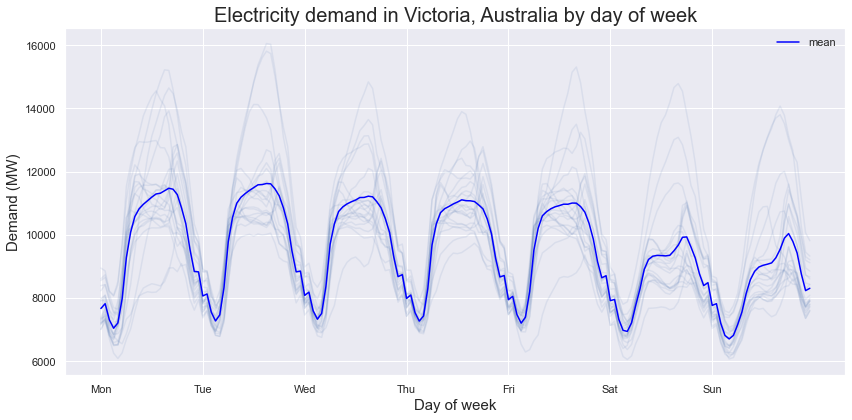

In [23]:
fig, ax = plt.subplots(figsize=[12, 6])

weekly_ts = []
sns_blue = sns.color_palette(as_cmap=True)
DAYS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Iterate over each week
for week, ts in df_smpl.groupby("week"):
    ts = ts.reset_index()
    
    weekly_ts.append(ts["demand"]) # Store the weekly time series 
    ts["demand"].plot( # Plot the weekly time series
        alpha=0.1, ax=ax, label="_no_legend_", color=sns_blue)
    
    plt.xticks(ticks=np.arange(0, 167, 24), labels=DAYS)

pd.concat(weekly_ts, axis=1).mean(axis=1).plot( # Compute average over all weeks and plot average
    ax=ax, color="blue", label="mean", legend=True
)

ax.set_ylabel("Demand (MW)")
ax.set_title("Electricity demand in Victoria, Australia by day of week")
ax.set_xlabel("Day of week")
ax.legend(loc="upper right", frameon=False)

plt.tight_layout();

In [24]:
mstl = MSTL(df_smpl["demand"], periods=(24, 24 * 7), stl_kwargs={"seasonal_deg": 0})
res = mstl.fit()

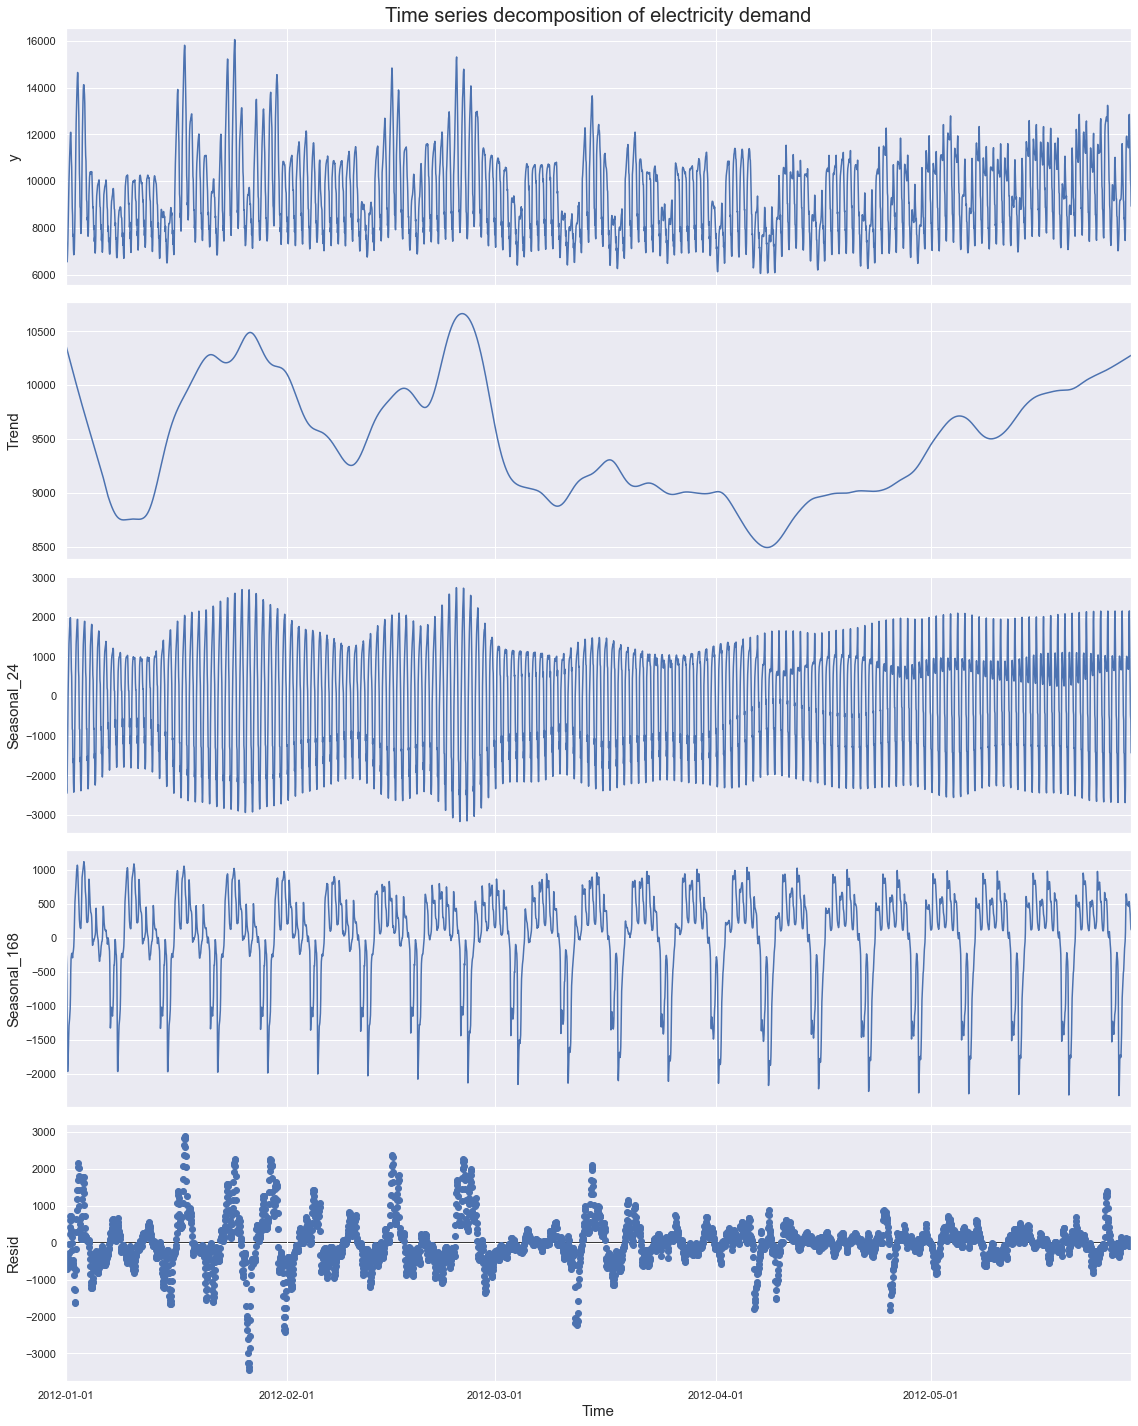

In [25]:
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

ax_last = axs[-1]
ax_last.xaxis.set_ticks(pd.date_range(start="2012-01-01", freq="MS", periods=5))
plt.setp(ax_last.get_xticklabels(), rotation=0, horizontalalignment="center")
for ax in axs[:-1]:
    ax.get_shared_x_axes().join(ax, ax_last)
    ax.xaxis.set_ticks(pd.date_range(start="2012-01-01", freq="MS", periods=5))
    ax.set_xticklabels([])
axs[0].set_ylabel("y")
axs[0].set_title("Time series decomposition of electricity demand")
ax_last.set_xlabel("Time")

plt.tight_layout()

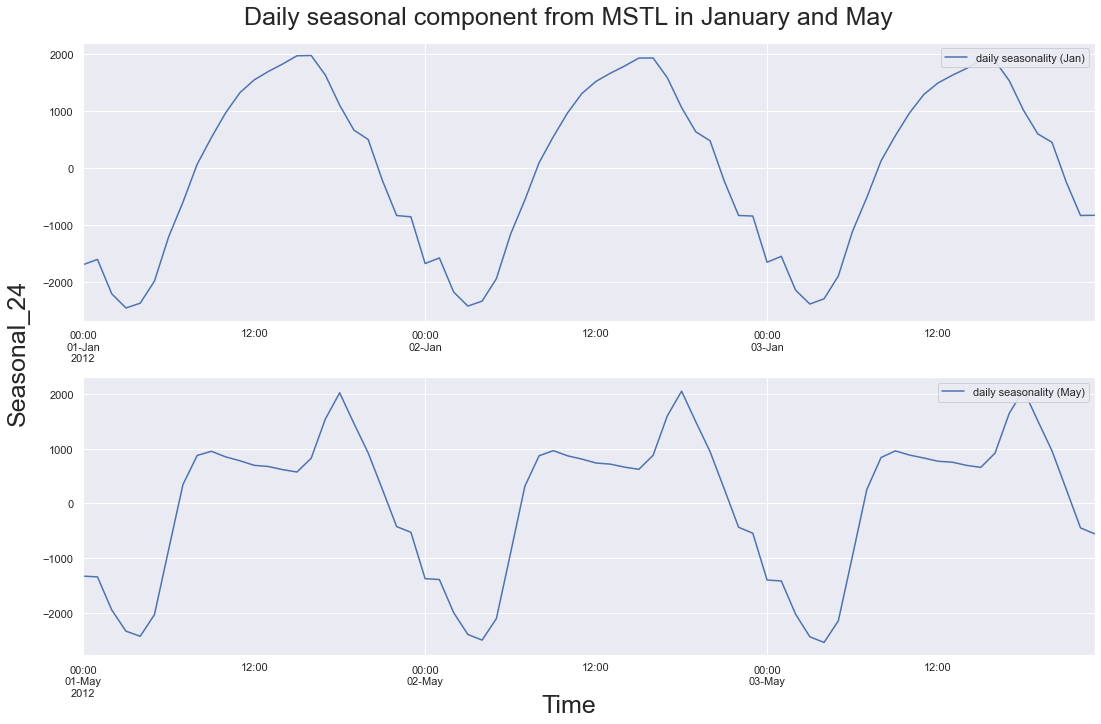

In [26]:
fig, ax = plt.subplots(nrows=2, figsize=[15, 10])
ax = ax.flatten()

# Plot daily seasonality in January
res.seasonal["seasonal_24"].iloc[: 24 * 3].plot(
    ax=ax[0], label="daily seasonality (Jan)", legend=True
)
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].legend(loc="upper right", framealpha=0.9)

# Plot daily seasonality in May
mask = res.seasonal.index.month == 5
res.seasonal[mask]["seasonal_24"].iloc[: 24 * 3].plot(
    ax=ax[1], label="daily seasonality (May)", legend=True
)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="upper right", framealpha=0.9)

# Figure labels
fig.suptitle("Daily seasonal component from MSTL in January and May", fontsize=25)
fig.text(0.5, 0, "Time", ha="center", fontsize=25)
fig.text(-0.02, 0.5, "Seasonal_24", va="center", rotation="vertical", fontsize=25)

plt.tight_layout()

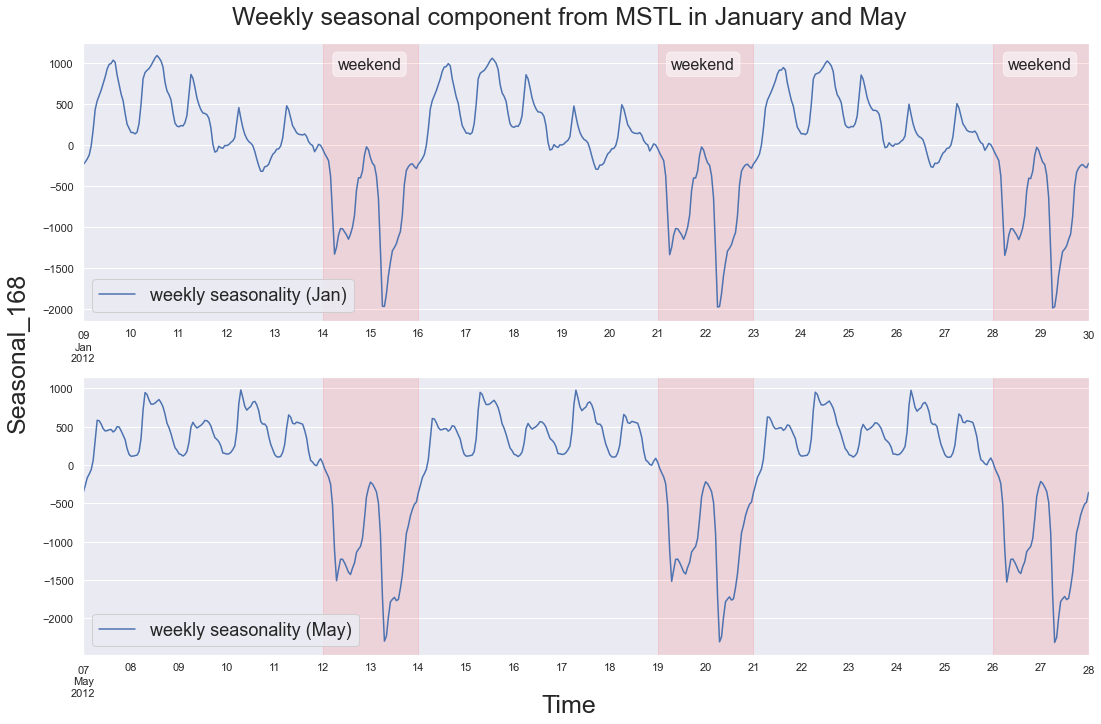

In [27]:
fig, ax = plt.subplots(nrows=2, figsize=[15, 10])
ax = ax.flatten()

# Plot weekly seasonality in January
start = pd.Timestamp("2012-01-09")  # Monday
end = start + pd.Timedelta("3W")
res.seasonal["seasonal_168"].loc[start:end].plot(
    ax=ax[0], label="weekly seasonality (Jan)", legend=True
)
ax[0].set_ylabel("seasonal_168")
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].legend(loc="lower left", framealpha=0.9, fontsize=18)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.253,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.585,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.92,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

weekends = [
    ("2012-01-14", "2012-01-16"),
    ("2012-01-21", "2012-01-23"),
    ("2012-01-28", "2012-01-30"),
]
for start_, end_ in weekends:
    ax[0].axvspan(start_, end_, alpha=0.1, color="red")

# Plot weekly seasonality in May
mask = res.seasonal.index.month == 5
start = pd.Timestamp("2012-05-7")
end = start + pd.Timedelta("3W")
res.seasonal[mask]["seasonal_168"].loc[start:end].plot(
    ax=ax[1], label="weekly seasonality (May)", legend=True
)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="lower left", framealpha=0.9, fontsize=18)

weekends = [
    ("2012-05-12", "2012-05-14"),
    ("2012-05-19", "2012-05-21"),
    ("2012-05-26", "2012-05-28"),
]
for start_, end_ in weekends:
    ax[1].axvspan(start_, end_, alpha=0.1, color="red")

# Figure labels
fig.suptitle("Weekly seasonal component from MSTL in January and May", fontsize=25)
fig.text(0.5, 0, "Time", ha="center", fontsize=25)
fig.text(-0.02, 0.5, "Seasonal_168", va="center", rotation="vertical", fontsize=25)

plt.tight_layout()

# Missing Data Imputation

### ffill & bfill

In [28]:
df = pd.read_csv(
    "Datasets/example_retail_sales_with_missing_data.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

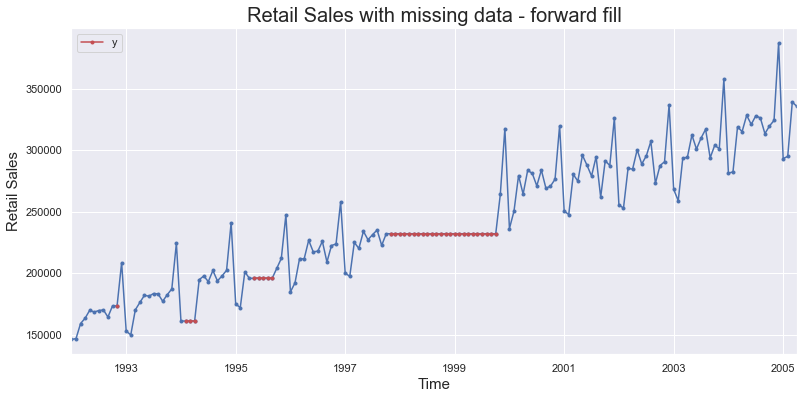

In [29]:
#ffill

df_ffill = df.fillna(method="ffill")

ax = df_ffill.plot(figsize = (13, 6), marker = ".", legend = None);
df_ffill[df.isnull()].plot(ax=ax, c = 'r', marker=".");

ax.set_title("Retail Sales with missing data - forward fill");
ax.set_ylabel("Retail Sales");
ax.set_xlabel("Time");

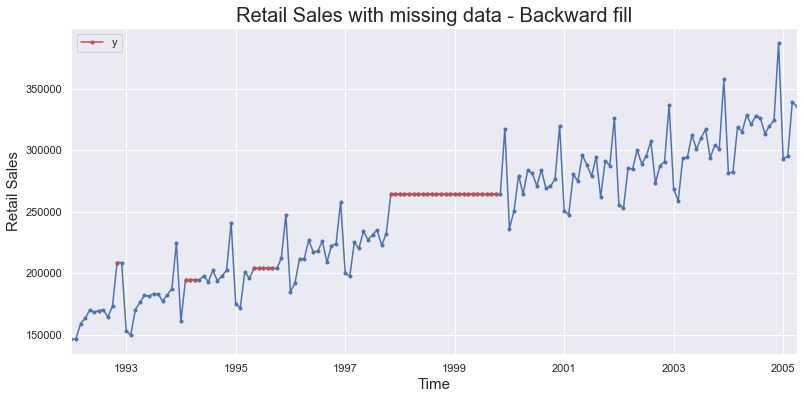

In [30]:
#bfill

df_bfill = df.fillna(method="bfill")

ax = df_bfill.plot(figsize = (13, 6), marker = ".", legend = None);
df_bfill[df.isnull()].plot(ax=ax, c = 'r', marker=".");

ax.set_title("Retail Sales with missing data - Backward fill");
ax.set_ylabel("Retail Sales");
ax.set_xlabel("Time");

### Linear Interpolation

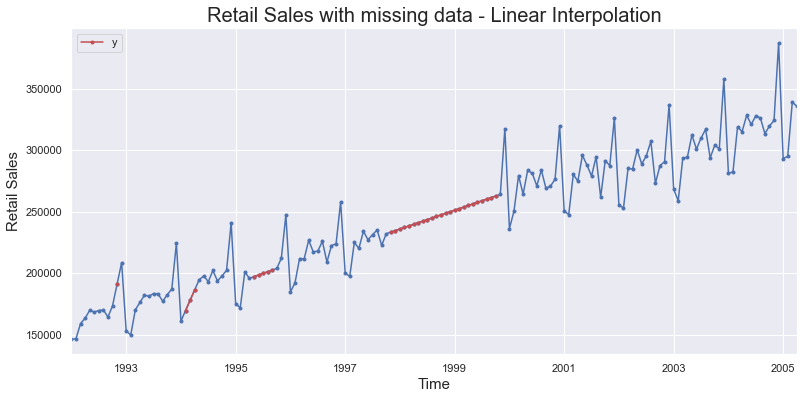

In [31]:
#linear

df_lin = df.interpolate(method = "linear")

ax = df_lin.plot(figsize = (13, 6), marker = ".", legend = None);
df_lin[df.isnull()].plot(ax=ax, c = 'r', marker=".");

ax.set_title("Retail Sales with missing data - Linear Interpolation");
ax.set_ylabel("Retail Sales");
ax.set_xlabel("Time");

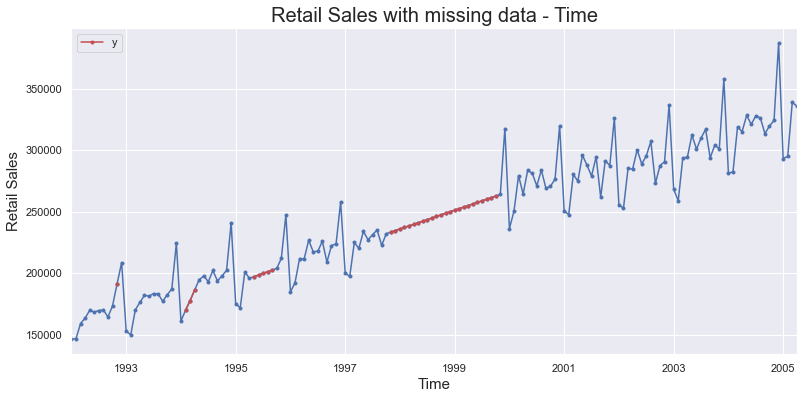

In [32]:
#linear

df_time = df.interpolate(method = "time")

ax = df_time.plot(figsize = (13, 6), marker = ".", legend = None);
df_time[df.isnull()].plot(ax=ax, c = 'r', marker=".");

ax.set_title("Retail Sales with missing data - Time");
ax.set_ylabel("Retail Sales");
ax.set_xlabel("Time");

### Spline

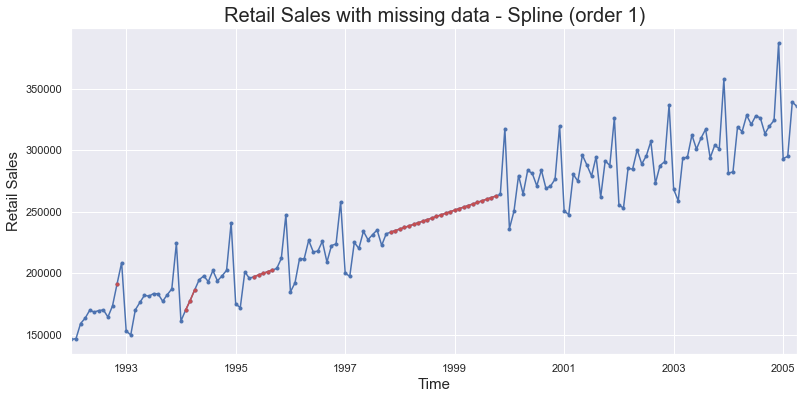

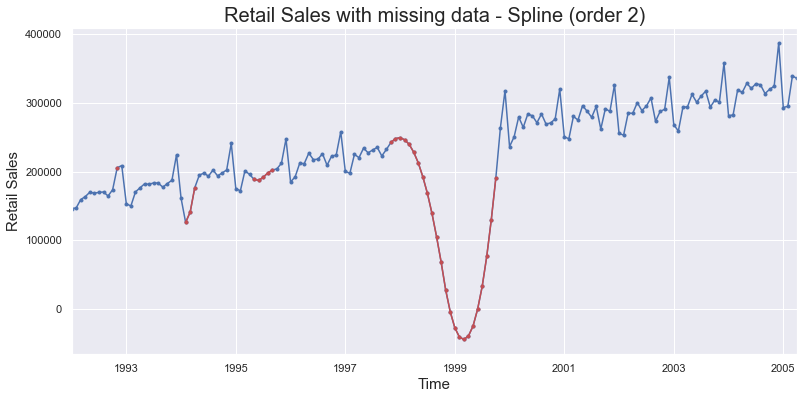

In [33]:
for i in np.arange(1, 3):
    df_spline = df.interpolate(method = "spline", order = i)

    ax = df_spline.plot(figsize = (13, 6), marker = ".", legend = None);
    df_spline[df.isnull()].plot(ax=ax, c = 'r', marker=".", legend = None);

    ax.set_title(f"Retail Sales with missing data - Spline (order {i})");
    ax.set_ylabel("Retail Sales");
    ax.set_xlabel("Time");
    plt.show()

#### Imputation using STL

This method could help impute missing values that captures bith trend and seasonality of the datasets. The steps involved are:

* extract the seasonal component
* de-seasonalise the original time series
* perform linear interpolation on the de-seasonalised data
* Add the seasonal component back to the imputed de-seasonalised data

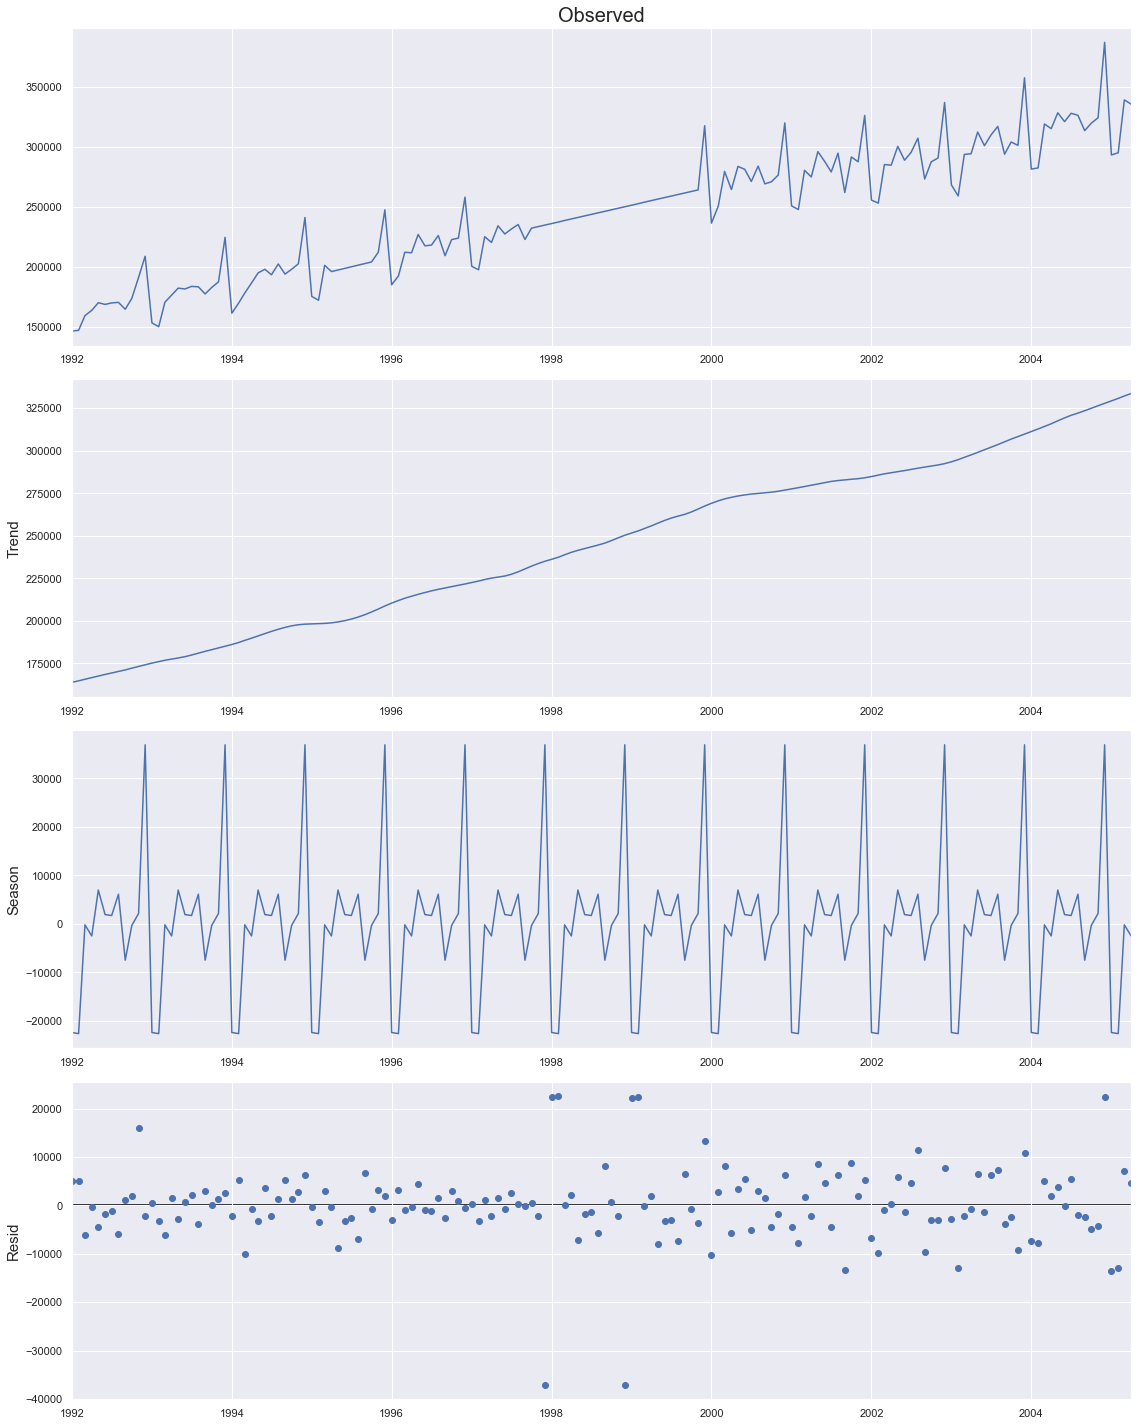

In [34]:
# Apply STL decomposition
res = STL(df.interpolate(method="linear"), seasonal=1001, seasonal_deg = 0).fit()

res.plot();

In [35]:
ssnlty = res.seasonal
ssnlty.head()

ds
1992-01-01   -22423.226765
1992-02-01   -22649.403191
1992-03-01     -219.416617
1992-04-01    -2510.512471
1992-05-01     6944.312081
Name: season, dtype: float64

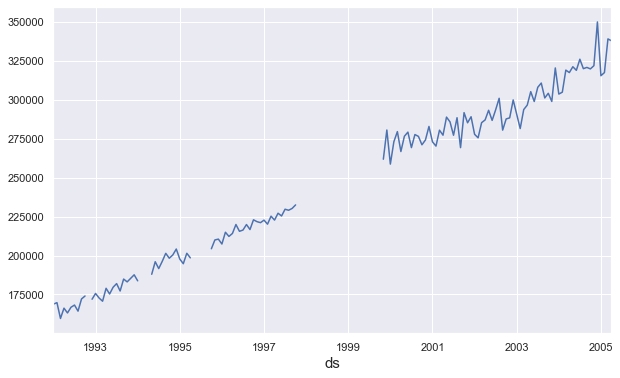

In [36]:
#deasonalize original ts
df_dessnl = df["y"] - ssnlty

df_dessnl.plot(figsize = (10, 6));

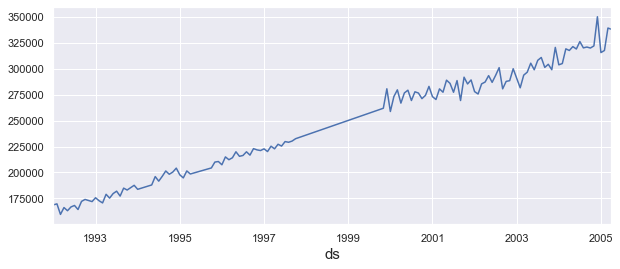

In [37]:
#linear interpolate missing values on the deseasonalized ts
df_dessnl_imputed = df_dessnl.interpolate() #default method is linear

df_dessnl_imputed.plot(figsize = (10, 4));

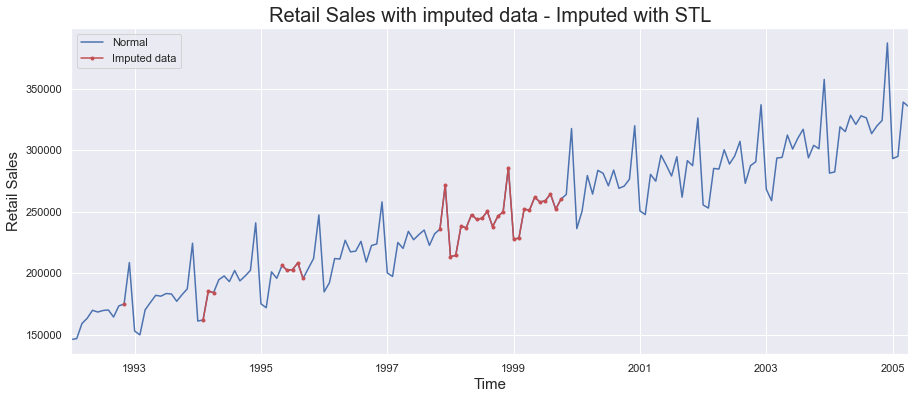

In [38]:
#add seasonality to the deseasonalized ts

df_stl_imputed = (df_dessnl_imputed + ssnlty).to_frame().rename(columns = {0 : "y"})

ax = df_stl_imputed.plot(figsize = (15, 6));
df_stl_imputed[df.isnull()].plot(marker = '.', c = 'r', ax = ax)

ax.legend(labels = ["Normal", "Imputed data"]);
ax.set_title("Retail Sales with imputed data - Imputed with STL");
ax.set_ylabel("Retail Sales");
ax.set_xlabel("Time");

# Detectng Outliers

### Rolling Mean

In [39]:
df = pd.read_csv(
    "Datasets/example_retail_sales_with_outliers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

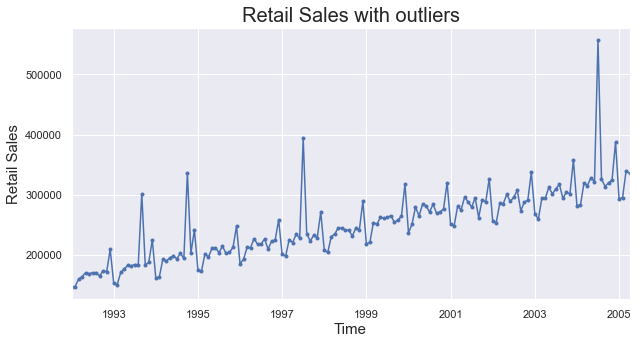

In [40]:
ax = df.plot(figsize = (10, 5), marker = '.', legend = None);
ax.set_title("Retail Sales with outliers");
ax.set_ylabel("Retail Sales");
ax.set_xlabel("Time");

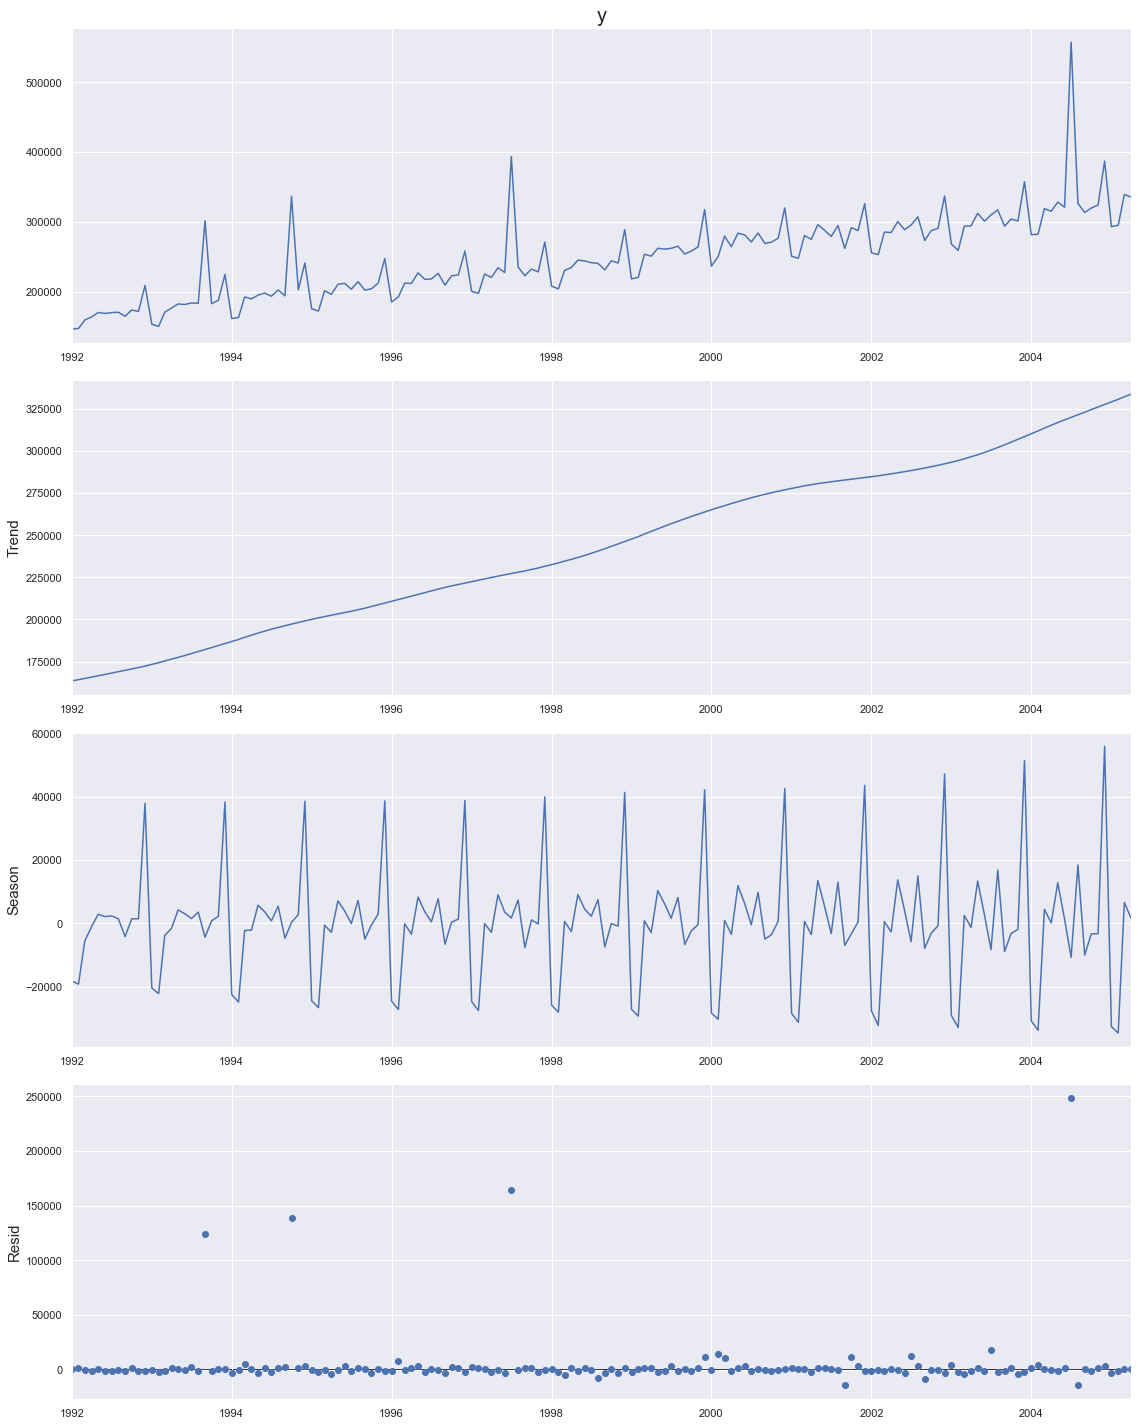

In [41]:
#First extract the seasonality to later de-seasonalize the ts

res = STL(df['y'],robust = True).fit()
res.plot();

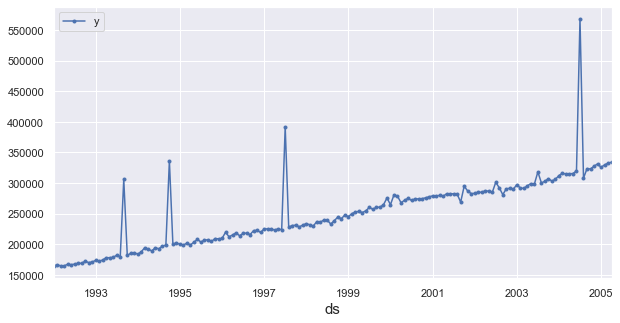

In [42]:
de_ssnl_df = (df['y'] - res.seasonal).to_frame('y')

de_ssnl_df.plot(figsize = (10, 5), marker = '.');

#### Estimation methods: Rolling mean

In [43]:
rolling_avg_stats = \
de_ssnl_df['y'].rolling(
        window = 12,# Yearly seasonality
        min_periods = 1, # Min periods set to 1 so that edge cases also have estimates
        center = True
).agg({'rolling_avg' : 'mean', 'rolling_std' : 'std'})


df_rolling_avg = pd.concat([de_ssnl_df, rolling_avg_stats], axis = 1)
df_rolling_avg.head()

,y,rolling_avg,rolling_std
ds,,,
1992-01-01,164493.495889,165622.552337,1130.452750
1992-02-01,166194.124261,165890.339378,1251.760952
1992-03-01,164808.704639,166261.547409,1563.785489
1992-04-01,164603.499381,166537.395234,1680.647235
1992-05-01,167157.131519,167101.829539,2386.753924


In [44]:
#rolling_avg is the expected value

# Apply the threshold criteria to identify an outlier
factor = 3

df_rolling_avg["is_outlier"] = np.abs(df_rolling_avg["y"] - df_rolling_avg["rolling_avg"]) > factor * df_rolling_avg["rolling_std"]

#finding upper and lower limits
df_rolling_avg["upper"] = df_rolling_avg["rolling_avg"] + factor * df_rolling_avg["rolling_std"]
df_rolling_avg["lower"] = df_rolling_avg["rolling_avg"] - factor * df_rolling_avg["rolling_std"]

df_rolling_avg.head()

,y,rolling_avg,rolling_std,is_outlier,upper,lower
ds,,,,,,
1992-01-01,164493.495889,165622.552337,1130.452750,False,169013.910587,162231.194087
1992-02-01,166194.124261,165890.339378,1251.760952,False,169645.622235,162135.056522
1992-03-01,164808.704639,166261.547409,1563.785489,False,170952.903877,161570.190941
1992-04-01,164603.499381,166537.395234,1680.647235,False,171579.336940,161495.453528
1992-05-01,167157.131519,167101.829539,2386.753924,False,174262.091311,159941.567768


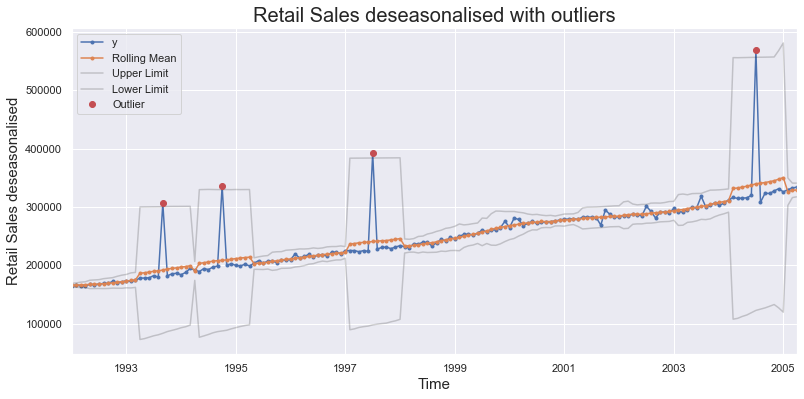

In [45]:
ax = df_rolling_avg.plot(y = ['y', 'rolling_avg'], figsize = (13, 6), marker = '.', label = None);
df_rolling_avg.plot(y = ['upper', 'lower'], ax = ax, c = 'k', alpha = 0.2, label = None);

df_rolling_avg.loc[df_rolling_avg['is_outlier'], 'y'].plot(c = 'r', marker = 'o', linestyle = '', ax = ax, label = None);

ax.legend(labels = ['y', 'Rolling Mean', 'Upper Limit', 'Lower Limit', 'Outlier']);

ax.set_title("Retail Sales deseasonalised with outliers");
ax.set_ylabel("Retail Sales deseasonalised");
ax.set_xlabel("Time");

from the above plot' we can see rolling mean is not robust to outliers as the rolling mean shifts a bit towards the outlier. In the next section we will use rolling median and check the results

#### Estimation methods: Rolling Median

##### alternative to standard deviation is the **median absolute deviation**

In [46]:
mad_func = lambda y: np.median(np.abs(y - np.median(y)))

In [47]:
rolling_med_stats = \
de_ssnl_df['y'].rolling(
        window = 12,# Yearly seasonality
        min_periods = 1, # Min periods set to 1 so that edge cases also have estimates
        center = True
).agg({'rolling_med' : 'median', 'rolling_MAD' : mad_func})


df_rolling_med = pd.concat([de_ssnl_df, rolling_med_stats], axis = 1)

# Apply the threshold criteria to identify an outlier
factor = 3.5 #check sourcr as to why when using rolling median 3.5 is the preferred default value

df_rolling_med["is_outlier"] = np.abs(df_rolling_med["y"] - df_rolling_med["rolling_med"]) > factor * df_rolling_med["rolling_MAD"]

#finding upper and lower limits
df_rolling_med["upper"] = df_rolling_med["rolling_med"] + factor * df_rolling_med["rolling_MAD"]
df_rolling_med["lower"] = df_rolling_med["rolling_med"] - factor * df_rolling_med["rolling_MAD"]

df_rolling_med.head()

,y,rolling_med,rolling_MAD,is_outlier,upper,lower
ds,,,,,,
1992-01-01,164493.495889,165501.414450,937.429476,False,168782.417616,162220.411283
1992-02-01,166194.124261,166194.124261,1302.937367,False,170754.405046,161633.843475
1992-03-01,164808.704639,166336.241297,1344.178495,False,171040.866028,161631.616565
1992-04-01,164603.499381,166478.358333,1669.653694,False,172322.146263,160634.570403
1992-05-01,167157.131519,166817.744926,1967.736600,False,173704.823024,159930.666828


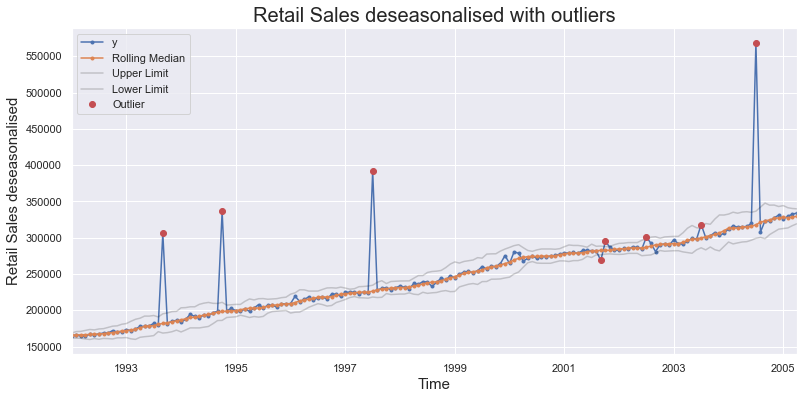

In [48]:
ax = df_rolling_med.plot(y = ['y', 'rolling_med'], figsize = (13, 6), marker = '.', label = None);
df_rolling_med.plot(y = ['upper', 'lower'], ax = ax, c = 'k', alpha = 0.2, label = None);

df_rolling_med.loc[df_rolling_med['is_outlier'], 'y'].plot(c = 'r', marker = 'o', linestyle = '', ax = ax, label = None);

ax.legend(labels = ['y', 'Rolling Median', 'Upper Limit', 'Lower Limit', 'Outlier']);

ax.set_title("Retail Sales deseasonalised with outliers");
ax.set_ylabel("Retail Sales deseasonalised");
ax.set_xlabel("Time");

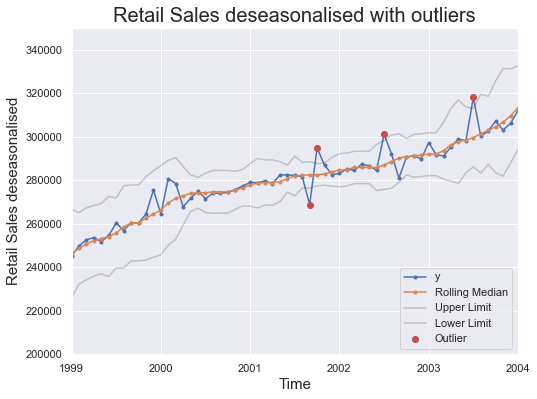

In [49]:
#zooming on to plots between 1999 and 2004

ax = df_rolling_med.plot(y = ['y', 'rolling_med'], figsize = (8, 6), marker = '.', label = None);
df_rolling_med.plot(y = ['upper', 'lower'], ax = ax, c = 'k', alpha = 0.2, label = None);

df_rolling_med.loc[df_rolling_med['is_outlier'], 'y'].plot(c = 'r', marker = 'o', linestyle = '', ax = ax, label = None);

ax.legend(labels = ['y', 'Rolling Median', 'Upper Limit', 'Lower Limit', 'Outlier']);

ax.set_title("Retail Sales deseasonalised with outliers");
ax.set_ylabel("Retail Sales deseasonalised");
ax.set_xlabel("Time");

ax.set_xlim('1999', '2004');
ax.set_ylim(200000, 350000);

Quoted from the source notes:

"As we can see the median and the MAD are more robust to outliers, there is not sudden change in the rolling median or MAD. We note both the MAD and the standard deviation will be proportional to the steepness of the trend. So the method may be more sensitive in areas with flatter trend: as we can see a smaller fluctuation in the data is identified as an outlier. A simple solution here would be to adjust the threshold. See this for yourself by increasing the factor variable above."

## Outlier Detection using Lowess

In [50]:
df_lowess = de_ssnl_df.copy()

In [51]:
#Fit a trend line using LOWESS and examine residuals
y = df_lowess['y'].values
x = np.arange(0, len(y), 1)

trend = lowess(y, x, frac = 0.1)
# print(f'Shape of trend array: {trend.shape}')
df_lowess['trend'] = trend[:, 1]

#compute residuals
df_lowess['residuals'] = df_lowess['y'] - df_lowess['trend']

#compute inter-quartile range
Q1 = df_lowess['residuals'].quantile(0.25)
Q3 = df_lowess['residuals'].quantile(0.75)
IQR = Q3 - Q1

# Apply some IQR as a threshold to identify outliers
factor = 3
df_lowess['upper'] = Q3 + factor * IQR
df_lowess['lower'] = Q1 - factor * IQR

df_lowess['is_outlier'] = (df_lowess['residuals'] < df_lowess['lower']) | (df_lowess['residuals'] > df_lowess['upper'])
df_lowess.head()

,y,trend,residuals,upper,lower,is_outlier
ds,,,,,,
1992-01-01,164493.495889,164121.229515,372.266374,10072.196725,-9891.803746,False
1992-02-01,166194.124261,164746.509329,1447.614932,10072.196725,-9891.803746,False
1992-03-01,164808.704639,165382.782243,-574.077604,10072.196725,-9891.803746,False
1992-04-01,164603.499381,166026.292837,-1422.793457,10072.196725,-9891.803746,False
1992-05-01,167157.131519,166672.981269,484.150250,10072.196725,-9891.803746,False


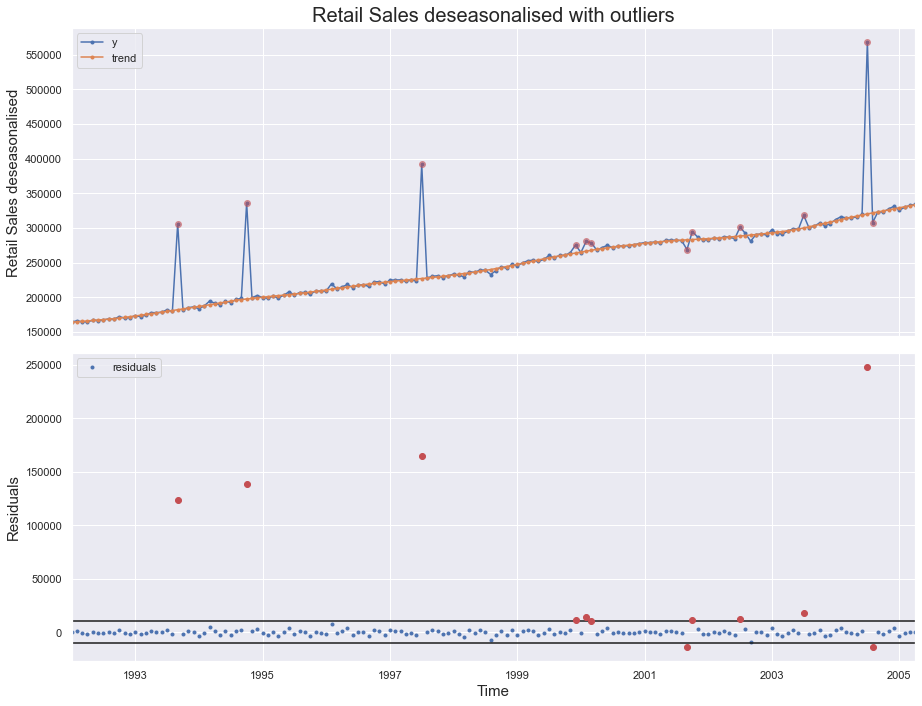

In [52]:
fig, ax = plt.subplots(2, 1, figsize=(13, 10), sharex=True)

#first subplot
df_lowess.plot(y = ["y", "trend"], marker = '.', ax = ax[0]);
df_lowess.loc[df_lowess['is_outlier'], 'y'].plot(ax = ax[0], c = 'r', marker = 'o', alpha = 0.5, linestyle = '');

#2nd plot - residuals
df_lowess.plot(y = ['residuals'], marker = '.', ax = ax[1], linestyle = '');
df_lowess.plot(y = ["upper", "lower"], ax = ax[1], c = 'k', legend = None);
df_lowess.loc[df_lowess['is_outlier'], 'residuals'].plot(ax = ax[1], c = 'r', marker = 'o', linestyle = '');

ax[0].set_title("Retail Sales deseasonalised with outliers");
ax[0].set_ylabel("Retail Sales deseasonalised");
ax[1].set_ylabel("Residuals");
ax[1].set_xlabel("Time");

plt.tight_layout();

"As we can see the residual method is much more sensitive and identified even smaller flucatuations in the data. The outliers are much clearer in the residual plot. To make the methods less sensitive, a simple solution would be to adjust threshold."

### Outlier detection using STL

In [53]:
df_stl = df.copy()

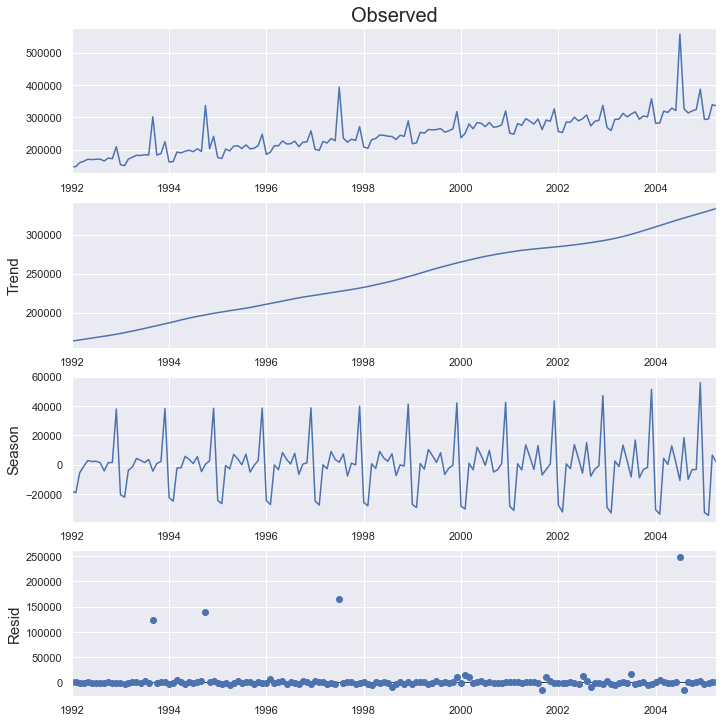

In [54]:
res = STL(df_stl, robust = True).fit()

plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
res.plot();

In [62]:
df_stl['residuals'] = res.resid

#compute inter-quartile range
Q1 = df_stl['residuals'].quantile(0.25)
Q3 = df_stl['residuals'].quantile(0.75)
IQR = Q3 - Q1

# Apply some IQR as a threshold to identify outliers
factor = 3
df_stl['upper'] = Q3 + factor * IQR
df_stl['lower'] = Q1 - factor * IQR

df_stl['is_outlier'] = (df_stl['residuals'] < df_stl['lower']) | (df_stl['residuals'] > df_stl['upper'])

# including trend and seasonality
df_stl["yhat = seasonal + trend"] = res.seasonal + res.trend

df_stl.head()

,y,residuals,upper,lower,is_outlier,yhat = seasonal + trend
ds,,,,,,
1992-01-01,146376.0,984.653087,10131.054011,-10007.511686,False,145391.346913
1992-02-01,147079.0,1922.820053,10131.054011,-10007.511686,False,145156.179947
1992-03-01,159336.0,-233.773804,10131.054011,-10007.511686,False,159569.773804
1992-04-01,163669.0,-1218.191626,10131.054011,-10007.511686,False,164887.191626
1992-05-01,170068.0,548.978491,10131.054011,-10007.511686,False,169519.021509


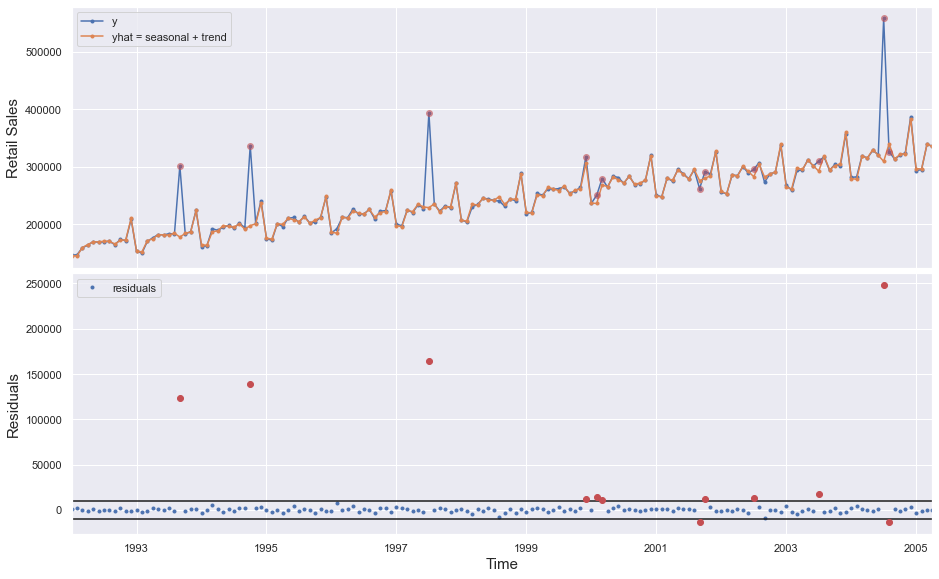

In [64]:
fig, ax = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

#first subplot
df_stl.plot(y = ["y", "yhat = seasonal + trend"], marker = '.', ax = ax[0]);
df_stl.loc[df_stl['is_outlier'], 'y'].plot(ax = ax[0], c = 'r', marker = 'o', alpha = 0.5, linestyle = '');

#2nd plot - residuals
df_stl.plot(y = ['residuals'], marker = '.', ax = ax[1], linestyle = '');
df_stl.plot(y = ["upper", "lower"], ax = ax[1], c = 'k', legend = None);
df_stl.loc[df_stl['is_outlier'], 'residuals'].plot(ax = ax[1], c = 'r', marker = 'o', linestyle = '');

ax[0].set_ylabel('Retail Sales')
ax[1].set_ylabel('Residuals')
ax[1].set_xlabel('Time')

plt.tight_layout();

We can also visualise the residuals for outliers using a histogram and box plot. This also allows us to check that the data is approximately normal.

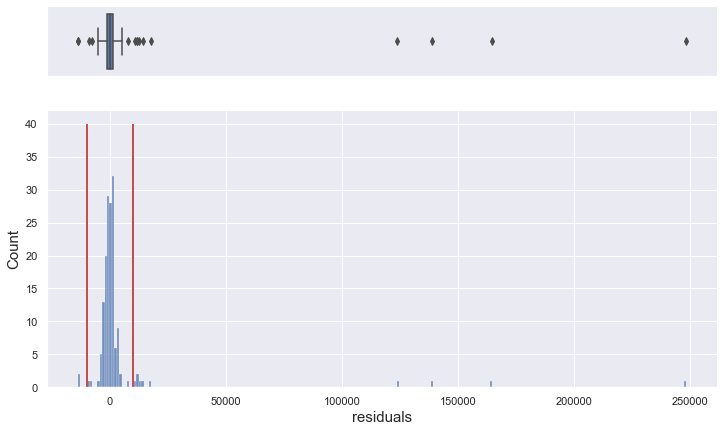

In [66]:
f, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.20, 0.80)}, figsize=[12, 7]
)
sns.boxplot(x=df_stl["residuals"], ax=ax_box)
sns.histplot(x=df_stl["residuals"], ax=ax_hist)

ax_box.axes.get_xaxis().set_visible(False)
ax_box.axes.get_yaxis().set_visible(False)

ax_hist.vlines(df_stl['lower'], 0, 40, color="r")
ax_hist.vlines(df_stl['upper'], 0, 40, color="r")
sns.despine()
plt.show()

"As we can see the residual method is much more sensitive and identified even smaller fluctuations in the data. The outliers are much clearer in the residual plot. To make the methods less sensitive, a simple solution here would be to adjust threshold."